# Statistical subgrid model for ISM clumping

This jupyter notebook contains functions and equations for the statistical subgrid clumping model presented in Buck et al. 2021b. Section "Theoretical model" contains the equations to calculate the cloud scale covering fraction as derived in section 2 and 3 of Buck et al. 2021. We accompany this with a little example how to sample valid clumping factors for a given ISM density following Fig. 4 of Buck et al. 2021. With this it should be straight forward to employ this model.  

Additionally it contains the plotting routines to recreate all figures from that paper. 

If you are using this model or parts of the code or data provided with jupyter notebook wekindly ask youto cite the corresponding paper as well as acknowledging the original source of the simulation data, the SILCC project (Walch et al. 2015, http://silcc.mpa-garching.mpg.de) 

## Function Definitions

Simulation analysis relies on the yt package (https://yt-project.org) and the healpix python utilities provided by the healpy package (https://healpy.readthedocs.io/en/latest/).

In [293]:
# load python packages
import yt
#from astropy import units as u
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from ISM_functions import *
import warnings

from scripts_update import *

from scipy import special

import matplotlib.gridspec as gridspec

In [294]:
# matplotlib style definitions
plt.rcParams['figure.figsize'] = (10, 10)

#sns.set_style('ticks')
#sns.set_style('darkgrid')
#sns.set_context("talk",font_scale=2,rc={"lines.linewidth": 4,"axes.linewidth": 5})

plt.rc('axes', linewidth=3)
plt.rcParams['axes.labelsize'] = 35 #'large'
plt.rcParams['xtick.labelsize'] = 35 #'large'
plt.rcParams['xtick.major.pad'] = 12
plt.rcParams['ytick.labelsize'] = 35 #'large'
plt.rcParams['ytick.major.pad'] = 12
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
#plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'#'gray'
plt.rcParams["lines.linewidth"] = 3
#plt.rcParams['axes.grid'] = True
#plt.rcParams['grid.color'] = 'lightgray'
#plt.rcParams['grid.linestyle'] = 'dashed' #dashes=(5, 1)
#plt.rcParams['lines.dashed_pattern'] = 10, 3
#plt.rcParams['grid.linewidth'] = 1.5
#plt.rcParams['axes.facecolor'] = 'whitesmoke'
#plt.rcParams['axes.axisbelow'] = True
plt.rcParams['legend.fancybox'] = True
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.shadow'] = False
plt.rcParams['legend.edgecolor'] = 'lightgray'
plt.rcParams['patch.linewidth'] = 3
plt.rcParams['text.usetex'] = True

In [295]:
# constants

pc = 3.086e+18 #parsec in cm
p_mass = 1.6726231e-24 #proton mass in grams

In [296]:
# some data loading function
def od_get_data(filename):
    '''
    Unpacks a dataset (pickle file) created with the function cover_dom_mpv_overlap.
    
    
    Parameters
    ----------
    filename  : name of the pickle file containing the data
    
    
    Returns
    ----------
    den, col_den, median_mp, avg_mp, centers
    '''
    
    with open(filename, "rb") as all_data:
        data = pickle.load(all_data)
        
    den  = data['density'] 
    col_den = data['column_density']
    median_mp = data['median'] 
    avg_mp = data['average']
    centers = data['centers']
    
    
    return den, col_den, median_mp, avg_mp, centers



In [403]:
# function definition to plot column density vs. density
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

def create_plot(filename, p=False):
    '''
    Creates a plot of the log10 of the median column density within the sampled spheres as a 
    function of the log10 of density of those spheres.
    
    Parameters
    ----------
    filename : the name of the data file
    
    
    Returns
    ----------
    
    Plot of log10 of median column density within the sampled spheres as a 
    function of the log10 of density of those spheres.
    
    If p parameter set to True, also saves figure.
    
    '''
    
    pattern = r'\d*\.\d+|\d+'

    nums = re.findall(pattern, filename)
    
    with open(filename, "rb") as all_data:
        data = pickle.load(all_data)
        
    den  = data['density'] 
    col_den = data['column_density']
    median_mp = data['median'] 
    avg_mp = data['average']
    centers = data['centers']
    
    pc = 3.085e18
    rad = int(nums[3])
    nside = int(nums[1])
    A = 4 * np.pi * (rad*pc)**2

    #area of a pixel in cm^2
    A_cm = A/hp.nside2npix(nside)
    
    n_H = 6.026e+23 #number of hydrogen atoms in one gram of gas

    cov = []
    #col_den = col_den.reshape(len(den),hp.nside2npix(nside))

    #particles per cm^2 
    b = col_den/A_cm #*n_H
            
    cf0 = [] #clumping factor computation
    
    mean = np.mean(col_den,axis=1)
    median = np.median(col_den,axis=1)
    cf0 = np.exp(2*np.log(mean/median))
    
    list_cf = np.asarray(cf0)
    
    plt.figure(figsize=(13,10))
    plt.scatter(np.log10(den/p_mass), np.log10(np.median(b,axis=1)),c=np.log10(list_cf),edgecolor='w',lw=1,
                s=50,cmap='hot', vmin=np.log10(1.01), vmax=4, zorder=-1)
    plt.colorbar(label=r"$\log_{10} \mathcal{C}_\Sigma$")
    
    plt.title(r'$\rm{Sphere\, radius\, =\, %s\, pc}$'%rad, fontsize=35)
    #plt.xlabel(r"$\log\left(\bar{\rho}/\rm{cm^{-3}}\right)$")
    plt.xlabel(r"$\log_{10}\left(\left<\rho\right>_V/\rm{cm^{-3}}\right)$")
    plt.ylabel(r"$\log_{10}\left(\Sigma_0/[\rm{g\,cm^{-2}}]\right)$")
    plt.ylim(-9,-3)
        
    
    if p == True:
        plt.savefig("nside{}_{}pc_R{}_{}.pdf".format(nums[1],nums[2], nums[3],nums[4]))
    
    print(min(list_cf), " ", max(list_cf))

## Theoretical model

In [206]:
# mass err function 
def mass_errf(dens,r,c,delta):
    """
    return covering fraction as a function of mass weighted density for
    radius r in pc
    clumping factor c
    and threshold delta in surface density
    """
    rho_hat = 3*delta/(r*pc*dens)
    mu_hat = -5*np.log(c)/4.
    sigma_hat = np.sqrt(0.5*np.log(c))

    z = (np.log(rho_hat) - mu_hat)/(np.sqrt(2)*sigma_hat)
    return 0.5*(1-special.erf(z))

In [408]:
# volume err function 
def volume_errf(dens,r,c,delta):
    """
    return covering fraction as a function of volume weighted density for
    radius r in pc
    clumping factor c
    and threshold delta in surface density
    This is equivalent to eq. 27 in Buck et al. 2021
    """
    rho_hat = 3*delta/(r*pc*dens)
    mu_hat = -1*np.log(c)/4.
    sigma_hat = np.sqrt(0.5*np.log(c))

    z = (np.log(rho_hat) - mu_hat)/(np.sqrt(2)*sigma_hat)
    return 0.5*(1-special.erf(z))

In [279]:
# log-normal
def lognorm(dens,dens_0,r,c):
    """
    log normal density distribution as in equation 17 using equation 24 to replace sigma_0
    dens in log scale
    radius r in pc
    clumping factor c 
    """
    sigma = np.sqrt(0.5*np.log(c))
    dens_1 = r*(10**dens_0)*np.exp(-5.*np.log(c)/4.)/3.
    
    return np.exp(-(dens-np.log(dens_1))**2. / (2 * sigma**2.))

### Figure 3: Model predictions

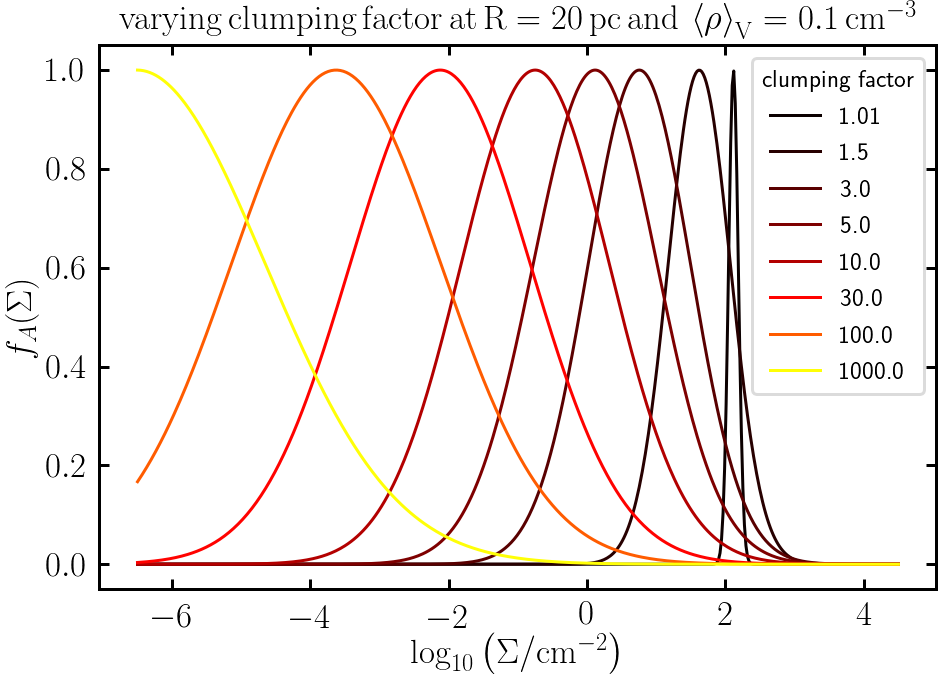

In [377]:
# old version of the left panel of Fig. 3 from Buck et al. 2021b 
C = [1.01,1.5,3.,5.,10.,30.,100.,1000.,10000.]
logC = np.log10(C)
colors = plt.cm.hot(logC/logC[-1])#np.linspace(0,1,len(C)+3))
dens = np.linspace(-6.5,4.5,500)

plt.figure(figsize=(15,10))
rad = 20
den0 = 0.1

for i in range(len(C)-1):
    plt.plot(dens,lognorm(dens,den0,rad,C[i]),color=colors[i], label=C[i])
    
plt.legend(title="clumping factor",title_fontsize=25,fontsize=25)
plt.ylabel(r"$f_A(\Sigma)$")
plt.xlabel(r"$\log_{10}\left(\Sigma/\rm{cm}^{-2}\right)$")
plt.title(r"$\rm{varying\, clumping\, factor\, at\, R=%s\,\rm{pc}\, and\, \left<\rho\right>_V=%s\,\rm{cm}^{-3}}$"%(rad,den0), fontsize=35)
plt.savefig("./plots/width.pdf", bbox_inches='tight')

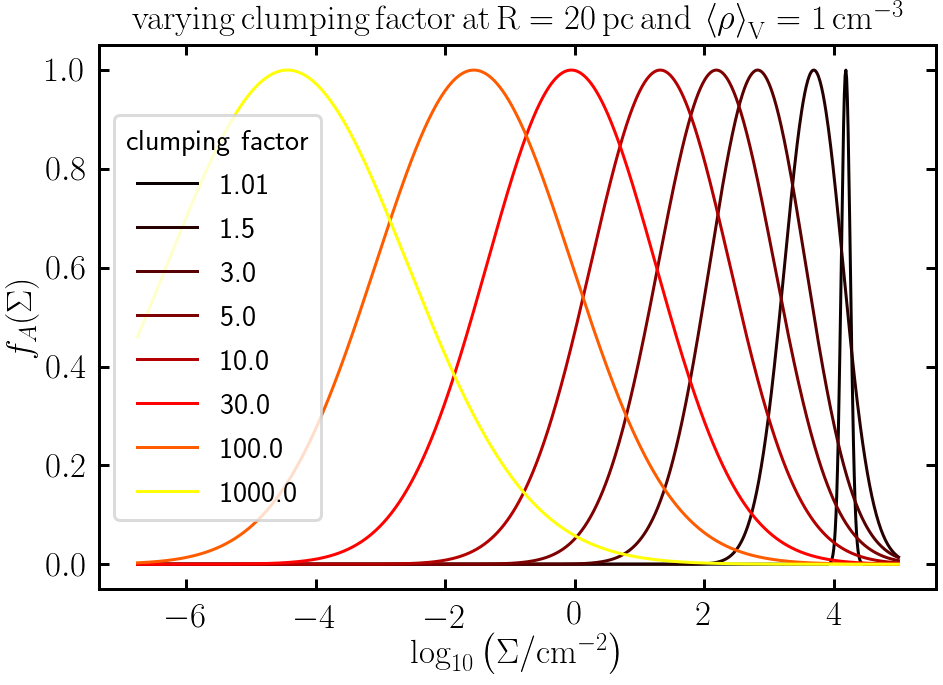

In [385]:
# left panel of Fig. 3 from Buck et al. 2021b 
C = [1.01,1.5,3.,5.,10.,30.,100.,1000.,10000.]
logC = np.log10(C)
colors = plt.cm.hot(logC/logC[-1])#np.linspace(0,1,len(C)+3))
dens = np.linspace(-6.75,5.,1000)

plt.figure(figsize=(15,10))
rad = 20
den0 = 1

for i in range(len(C)-1):
    plt.plot(dens,lognorm(dens,den0,rad,C[i]),color=colors[i], label=C[i])
    
plt.legend(title="clumping factor",title_fontsize=30,fontsize=30)
plt.ylabel(r"$f_A(\Sigma)$")
plt.xlabel(r"$\log_{10}\left(\Sigma/\rm{cm}^{-2}\right)$")
plt.title(r"$\rm{varying\, clumping\, factor\, at\, R=%s\,\rm{pc}\, and\, \left<\rho\right>_V=%s\,\rm{cm}^{-3}}$"%(rad,den0), fontsize=35)
plt.savefig("./plots/width.pdf", bbox_inches='tight')

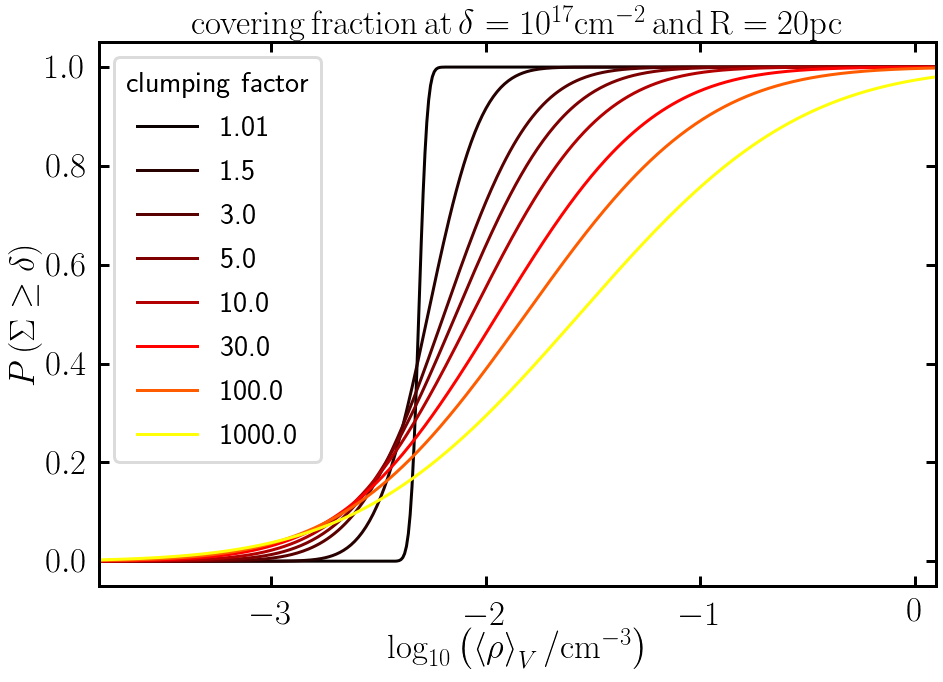

In [386]:
# right panel of Fig. 3
C = [1.01,1.5,3.,5.,10.,30.,100.,1000.,10000.]
logC = np.log10(C)
colors = plt.cm.hot(logC/logC[-1])#np.linspace(0,1,len(C)+3))
dens = np.linspace(-3.8,0.5,500)

plt.figure(figsize=(15,10))
th = 1e17
rad = 20

for i in range(len(C)-1):
    plt.plot(dens,volume_errf(10**dens,rad,C[i],th),color=colors[i], label=C[i])

plt.xlim(-3.8,0.1)
plt.legend(title="clumping factor",title_fontsize=30,fontsize=30)
plt.ylabel(r"$ P\left(\Sigma\geq\delta\right)$")#\,
plt.xlabel(r"$\log_{10}\left(\left<\rho\right>_V/\rm{cm}{^{-3}}\right)$")
plt.title(r"$\rm{covering\, fraction\, at\, \delta=10^{17}\rm{cm}^{-2}\, and\, R=%s\rm{pc}}$"%rad, fontsize=35)
plt.savefig("./plots/cov_frac.pdf", bbox_inches='tight')

## Paper Plots

### Figure 1: clumping factor from density vs clumping factor from column density

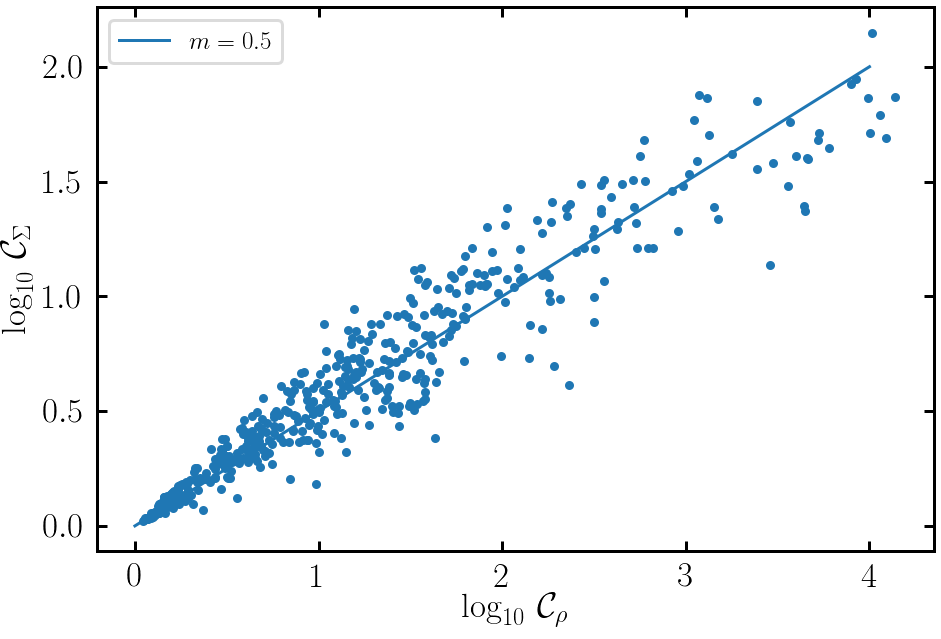

In [289]:
# Fig. 1: clumping factor from density vs clumping factor from column density for R=50 pc

plt.figure(figsize=(15,10))

# radius of the sphere in pc
rad = 50

density = []

for name in ['./data/data_cellprop_500_nside4_1pc_R50_6000']:
 
    data = get_data(name)
    cell_masses = data[4]
    cell_volumes  = data[5]
    den = data[0] / p_mass

    col_den = data[1]
    median_mp = data[2] 
    avg_mp = data[3]
    centers = data[6]
    
    pc = 3.085e18

    nside = 4
    A = 4 * np.pi * (rad*pc)**2

    #area of a pixel in cm^2
    A_cm = A/hp.nside2npix(nside)
    n_H = 6.026e+23 #number of hydrogen atoms in one gram of gas

    #clumping factor computation
    cf0 = [] 
    cf1 = []
    d = cell_masses/cell_volumes
    v = cell_volumes

    for i in range(500):
        numer = np.sum(d[i]**2*v[i])/np.sum(v[i])     
        denom = (np.sum(d[i]*v[i])/np.sum(v[i]))**2
        cf1.append(numer/denom)
    
    density.extend(den)
    cf2 = []
    col_den = col_den.reshape(len(den),hp.nside2npix(nside))
    
    mean = np.mean(col_den,axis=1)
    median = np.median(col_den,axis=1)
    cf2 = (mean/median_mp)
    
    #particles per cm^2 
    b = col_den/(A_cm*p_mass)
    cov = []
    for i in range(len(col_den)):
        numer = np.sum(b[i]**2)/np.sum(192)     
        denom = (np.sum(b[i])/np.sum(192))**2
        cf0.append(numer/denom)
        
c = plt.scatter(np.log10(cf1),np.log10(cf0))

plt.plot([0,4],[0,2],zorder=-1, label=r'$m=0.5$')

plt.legend(loc=2, fontsize=25)
plt.xlabel(r'$\log_{10}\,\mathcal{C}_\rho$')
plt.ylabel(r'$\log_{10}\,\mathcal{C}_\Sigma$')

plt.savefig("./plots/c_vs_c.pdf", bbox_inches='tight')

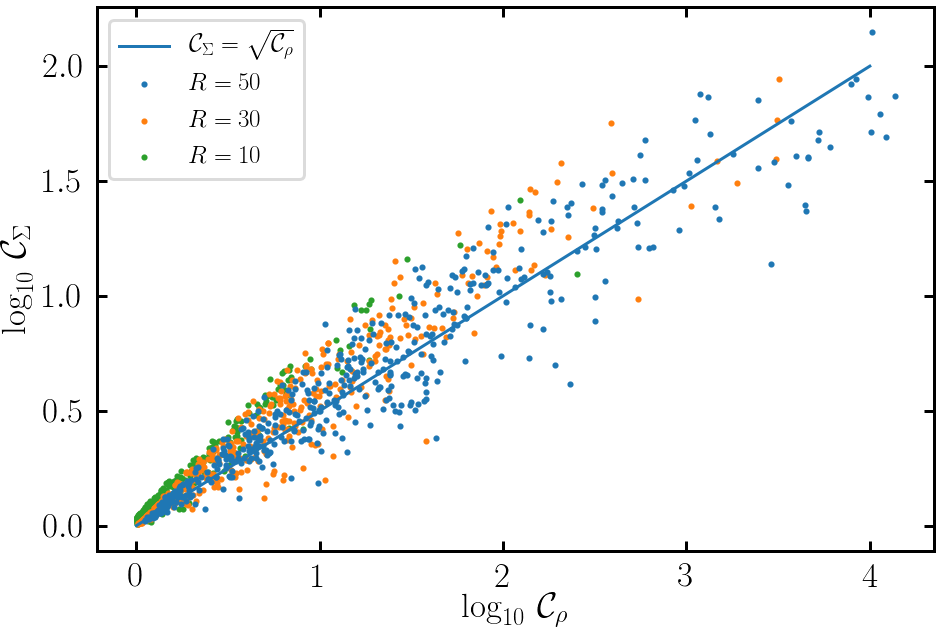

In [290]:
# Fig. 1: clumping factor from density vs clumping factor from column density for different radii

plt.figure(figsize=(15,10))

# radius of the sphere in pc
rad = [50,30,10] #[10,20,30,40,50]
order = [-1,-2,-13]
density = []

for j,name in enumerate(['./data/data_cellprop_500_nside4_1pc_R50_6000',
        './data/data_cellprop_500_nside4_1pc_R30_6000','./data/data_cellprop_500_nside4_1pc_R10_6000']):
 
    data = get_data(name)
    cell_masses = data[4]
    cell_volumes  = data[5]
    den = data[0] / p_mass

    col_den = data[1]
    median_mp = data[2] 
    avg_mp = data[3]
    centers = data[6]
    
    pc = 3.085e18

    nside = 4
    A = 4 * np.pi * (rad[j]*pc)**2

    #area of a pixel in cm^2
    A_cm = A/hp.nside2npix(nside)
    n_H = 6.026e+23 #number of hydrogen atoms in one gram of gas

    #clumping factor computation
    cf0 = [] 
    cf1 = []
    d = cell_masses/cell_volumes
    v = cell_volumes

    for i in range(500):
        numer = np.sum(d[i]**2*v[i])/np.sum(v[i])     
        denom = (np.sum(d[i]*v[i])/np.sum(v[i]))**2
        cf1.append(numer/denom)
    
    density.extend(den)
    cf2 = []
    col_den = col_den.reshape(len(den),hp.nside2npix(nside))
    
    mean = np.mean(col_den,axis=1)
    median = np.median(col_den,axis=1)
    cf2 = (mean/median_mp)
    
    #particles per cm^2 
    b = col_den/(A_cm*p_mass)
    cov = []
    for i in range(len(col_den)):
        numer = np.sum(b[i]**2)/np.sum(192)     
        denom = (np.sum(b[i])/np.sum(192))**2
        cf0.append(numer/denom)
        
    c = plt.scatter(np.log10(cf1),np.log10(cf0), zorder=order[j], s=10, label=r"$R=%i$"%rad[j])

plt.plot([0,4],[0,2],zorder=-1, label=r'$\mathcal{C}_\Sigma=\sqrt{\mathcal{C}_\rho}$')

plt.legend(loc=2, fontsize=25)
plt.xlabel(r'$\log_{10}\,\mathcal{C}_\rho$')
plt.ylabel(r'$\log_{10}\,\mathcal{C}_\Sigma$')

plt.savefig("./plots/c_vs_c_all.pdf", bbox_inches='tight')

### Figure 4: Distribution of clumping factors as a function of ISM density and sphere radius

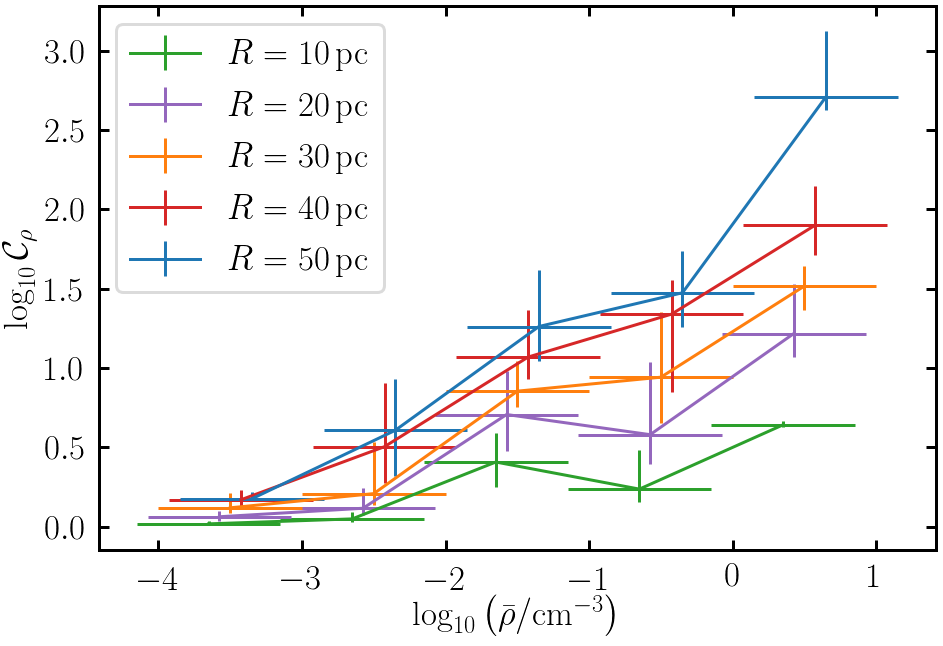

In [334]:
# Fig. 4: clumping factor for different sphere radii

cmap = plt.get_cmap("tab10")
color = [2,4,1,3,0]
names = ['./data/data_cellprop_500_nside4_1pc_R10_6000','./data/data_cellprop_500_nside4_1pc_R20_6000',
        './data/data_cellprop_500_nside4_1pc_R30_6000','./data/data_cellprop_500_nside4_1pc_R40_6000',
        './data/data_cellprop_500_nside4_1pc_R50_6000']
Range = (-4,1)
Nbin = 5

p_mass = 1.6726231e-24

fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
j = 1

for name,rad in zip(names,[10,20,30,40,50]):
    density = []
    clump = [] 

    data = get_data(name)
    cell_masses = data[4]
    cell_volumes  = data[5]
 
    cf0 = []
    
    #clumping factor computation
    d = cell_masses/cell_volumes
    v = cell_volumes

    for i in range(500):
        numer = np.sum(d[i]**2*v[i])/np.sum(v[i])     
        denom = (np.sum(d[i]*v[i])/np.sum(v[i]))**2

        cf0.append(numer/denom)

    den = data[0]
    
    density.extend(den)
    clump.extend(cf0)
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(np.log10(np.asarray(density)/p_mass),np.log10(np.asarray(clump)),
                            statistic='median',range=Range, bins=Nbin)
    
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    
    bin_Hquant, _, _ = stats.binned_statistic(np.log10(np.asarray(density)/p_mass),np.log10(np.asarray(clump)),
                            statistic=lambda y: np.percentile(y, 68),range=Range, bins=Nbin)
    bin_Lquant, _, _ = stats.binned_statistic(np.log10(np.asarray(density)/p_mass),np.log10(np.asarray(clump)),
                            statistic=lambda y: np.percentile(y, 34),range=Range, bins=Nbin)
    
    bin_std, _, _ = stats.binned_statistic(np.log10(np.asarray(density)/p_mass),np.log10(np.asarray(clump)),
                            statistic=np.std,range=Range, bins=Nbin)
    
    ax.errorbar(bin_centers+(j-3)*0.075,bin_means,xerr=[bin_width/2.]*len(bin_means),yerr=[bin_means-bin_Lquant,bin_Hquant-bin_means],c=cmap(color[j-1]),label=r'$R=%i\, \rm{pc}$'%rad)
    
    #print(rad)
    #print("means")
    #print(bin_means)
    #print("L quant")
    #print(bin_Lquant)
    #print("H quant")
    #print(bin_Hquant)
    #print("std")
    #print(bin_std)
    
    #for x,y,z in zip(np.round(bin_means,2),np.round(bin_Lquant,2),np.round(bin_Hquant,2)):
    #    print(str(x) + "$_{"+str(y)+"}^{"+str(z)+"}")

    j += 1
    
ax.set_xlabel(r"$\log_{10}\left(\bar{\rho}/\rm{cm^{-3}}\right)$")
ax.set_ylabel(r"$\log_{10}\mathcal{C}_\rho$")
ax.legend(fontsize=35,loc=2)
plt.savefig('./plots/c_vs_rho.pdf', bbox_inches='tight')

### Figure 2: density projections and example spheres with column density distribution

In [10]:
# load a SILCC snapshot. NOTE: the entire snapshot file is not provided. 
# We save the image as binary pickle file to replot.

path = './SILCC_hdf5_plt_cnt_6000'
#path = '/home/bogdan/ISM data/1 pc/SILCC_hdf5_plt_cnt_6000'
ds = yt.load(path)

dd = ds.all_data()

yt : [INFO     ] 2021-08-05 11:04:27,244 Parameters: current_time              = 1892198803082044.0
yt : [INFO     ] 2021-08-05 11:04:27,248 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2021-08-05 11:04:27,253 Parameters: domain_left_edge          = [-7.715e+20 -7.715e+20 -7.715e+20]
yt : [INFO     ] 2021-08-05 11:04:27,254 Parameters: domain_right_edge         = [7.715e+20 7.715e+20 7.715e+20]
yt : [INFO     ] 2021-08-05 11:04:27,255 Parameters: cosmological_simulation   = 0.0


In [11]:
# z-projection
p = yt.ProjectionPlot(ds, 'z', 'density')
z_img = np.array(p.data_source.to_frb((500, 'pc'), 512)['density'])
# x-projection
p = yt.ProjectionPlot(ds, 'x', 'density')
x_img = np.array(p.data_source.to_frb((500, 'pc'), 512)['density']).T
# y-projection
p = yt.ProjectionPlot(ds, 'y', 'density')
y_img = np.array(p.data_source.to_frb((500, 'pc'), 512)['density'])

/Users/buck/anaconda3/lib/python3.6/site-packages/yt/units/yt_array.py:978: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ret = super(YTArray, self).__getitem__(item)
/Users/buck/anaconda3/lib/python3.6/site-packages/yt/fields/fluid_fields.py:201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_field[slice_3d] = f
yt : [INFO     ] 2021-08-05 11:06:49,933 Projection completed
yt : [INFO     ] 2021-08-05 11:06:49,933 xlim = -771500000000000000000.000000 771500000000000000000.000000
yt : [INFO     ] 2021-08-05 11:06:49,934 ylim = -77150000

In [12]:
# save the density projections as pickle files
f = open('./data/density_projection.dat','wb')
pickle.dump({'z_img':z_img,'x_img':x_img,'y_img':y_img}, f)
f.close()

In [399]:
# get the example spheres
filename = './data/datav_500_nside4_1pc_R20_6000'

v_disp = []
den = []
col_den = []
median_mp = []
centers = []

with open(filename, "rb") as all_data:
    data = pickle.load(all_data)
    v_disp  = data['vel_disp']
    den     = data['density']
    col_den = data['column_density']
    median_mp  = data['median']
    centers = data['centers']

pattern = r'\d*\.\d+|\d+'
nside   = int(re.findall(pattern, filename)[1])
res     = float(re.findall(pattern, filename)[2])
rad     = int(re.findall(pattern, filename)[3])
snap    = int(re.findall(pattern, filename)[-1])

A = 4 * np.pi * (rad*pc)**2
A_cm = A/hp.nside2npix(nside)

In [400]:
# select the spheres by density cuts
lden1 = np.where(np.logical_and(np.log10(den) > -26,np.log10(den) < -25.5))
lden2 = np.where(np.logical_and(np.log10(median_mp/A_cm) > -7.,np.log10(median_mp/A_cm) < -6.5))

lden11 = np.where(np.logical_and(np.log10(den) > -27,np.log10(den) < -26.5))
lden22 = np.where(np.logical_and(np.log10(median_mp/A_cm) > -7.5,np.log10(median_mp/A_cm) < -7.2)) 

lden = np.intersect1d(lden1,lden2)
lden0 = np.intersect1d(lden11,lden22)

hden = np.where(np.logical_and(np.log10(den) > -22.5,np.log10(median_mp/A_cm)>-6))

hden11 = np.where(np.logical_and(np.log10(den) > -24.,np.log10(den) < -23.))
hden22 = np.where(np.logical_and(np.log10(median_mp/A_cm) > -6.5,np.log10(median_mp/A_cm) < -5.))

hden0 = np.intersect1d(hden11,hden22)

yellow = np.where(np.log10(den) > -21.5)

In [401]:
# get their position
pos = []

for i in range(len(hden)):
    pos.append(centers[hden[i]]/pc)

pos = pos[0]
    
pos1 = []
for i in range(len(hden0)):
    pos1.append(centers[hden0[i]]/pc)
    
    
posl = []

for i in range(len(lden)):
    posl.append(centers[lden][i]/pc)

posl1 = []
for i in range(len(lden0)):
    posl1.append(centers[lden0][i]/pc)
    
y = centers[yellow]/pc

# define index
h = 1 #0
l = 2 #1

s = 2 #1
t = 2

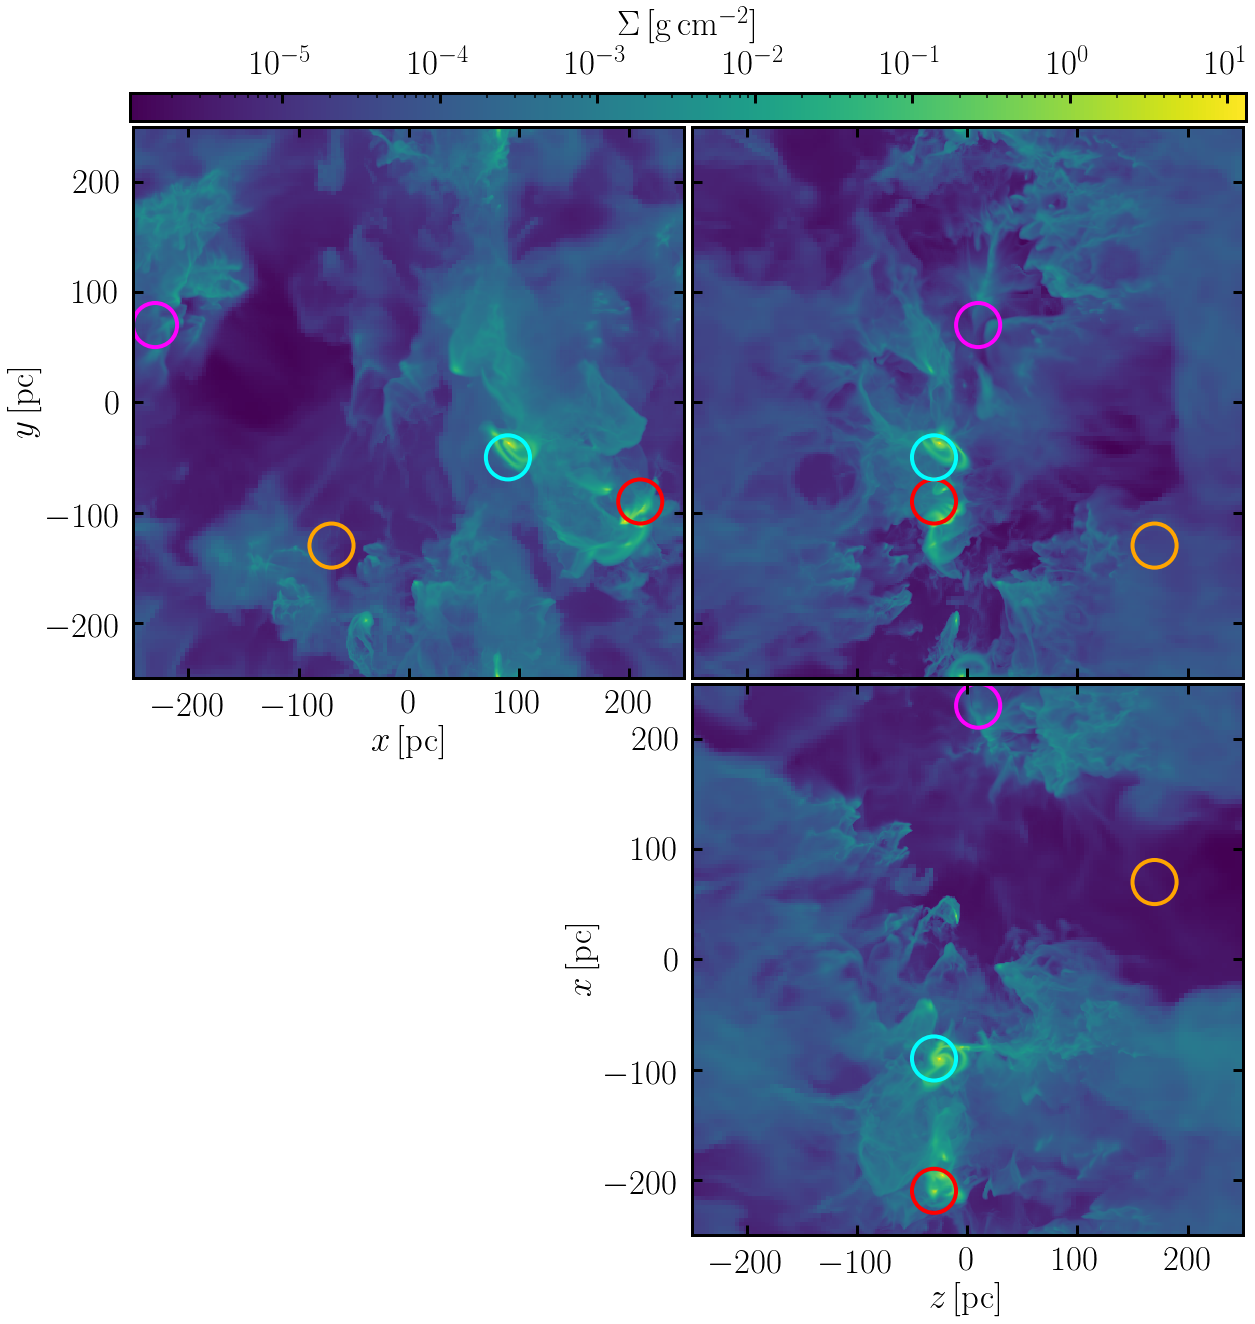

In [17]:
# Fig. 2 
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(20,21))
gs = gridspec.GridSpec(3, 2, width_ratios=[1,1], height_ratios=[.05,1,1])
gs.update(hspace=0.015, wspace=0.0015)

cax = plt.subplot(gs[0:2])
ax = plt.subplot(gs[2])
ax.set_ylabel(r"$y\, \rm{[pc]}$")
ax.set_xlabel(r"$x\, \rm{[pc]}$")

ax2 = plt.subplot(gs[3])
ax2.set_yticklabels([])
ax2.set_xticklabels([])

#ax3 = plt.subplot(gs[4])
ax4 = plt.subplot(gs[5])
ax4.set_ylabel(r"$x\, \rm{[pc]}$")
ax4.set_xlabel(r"$z\, \rm{[pc]}$")

data = pickle.load(open('./data/density_projection.dat','rb'))
z_img = data['z_img']
x_img = data['x_img']
y_img = data['y_img']

#p = yt.ProjectionPlot(ds, 'z', 'density')
c = ax.imshow(z_img, norm=LogNorm(), cmap='viridis', extent=(-250,250,-250,250))
cb = plt.colorbar(c, cax=cax, orientation='horizontal')
cb.set_label(label=r"$\Sigma\, \rm{[g\,cm^{-2}]}$", size=35, labelpad=15)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

circle = plt.Circle((pos[h][0],-pos[h][1]), 20, color='r', lw=4, fill=False)
ax.add_patch(circle)
circle2 = plt.Circle((pos[l][0],-pos[l][1]), 20, color='cyan', lw=4, fill=False)
ax.add_patch(circle2)
circle3 = plt.Circle((pos1[s][0],-pos1[s][1]), 20, color='magenta', lw=4, fill=False)
ax.add_patch(circle3)
circle4 = plt.Circle((posl1[t][0],-posl1[t][1]), 20, color='orange', lw=4, fill=False)
ax.add_patch(circle4)

#p = yt.ProjectionPlot(ds, 'x', 'density')
c = ax2.imshow(x_img, norm=LogNorm(), cmap='viridis', extent=(-250,250,-250,250))

circle = plt.Circle((pos[h][2],-pos[h][1]), 20, color='r', lw=4, fill=False)
ax2.add_patch(circle)
circle2 = plt.Circle((pos[l][2],-pos[l][1]), 20, color='cyan', lw=4, fill=False)
ax2.add_patch(circle2)
circle3 = plt.Circle((pos1[s][2],-pos1[s][1]), 20, color='magenta', lw=4, fill=False)
ax2.add_patch(circle3)
circle4 = plt.Circle((posl1[t][2],-posl1[t][1]), 20, color='orange', lw=4, fill=False)
ax2.add_patch(circle4)

#p = yt.ProjectionPlot(ds, 'y', 'density')
c = ax4.imshow(y_img, norm=LogNorm(), cmap='viridis', extent=(-250,250,-250,250))

circle = plt.Circle((pos[h][2],-pos[h][0]), 20, color='r', lw=4, fill=False)
ax4.add_patch(circle)
circle2 = plt.Circle((pos[l][2],-pos[l][0]), 20, color='cyan', lw=4, fill=False)
ax4.add_patch(circle2)
circle3 = plt.Circle((pos1[s][2],-pos1[s][0]), 20, color='magenta', lw=4, fill=False)
ax4.add_patch(circle3)
circle4 = plt.Circle((posl1[t][2],-posl1[t][0]), 20, color='orange', lw=4, fill=False)
ax4.add_patch(circle4)
plt.savefig("./plots/surf_den.pdf", bbox_inches='tight')

0.8457736963836763   189083776.37246218


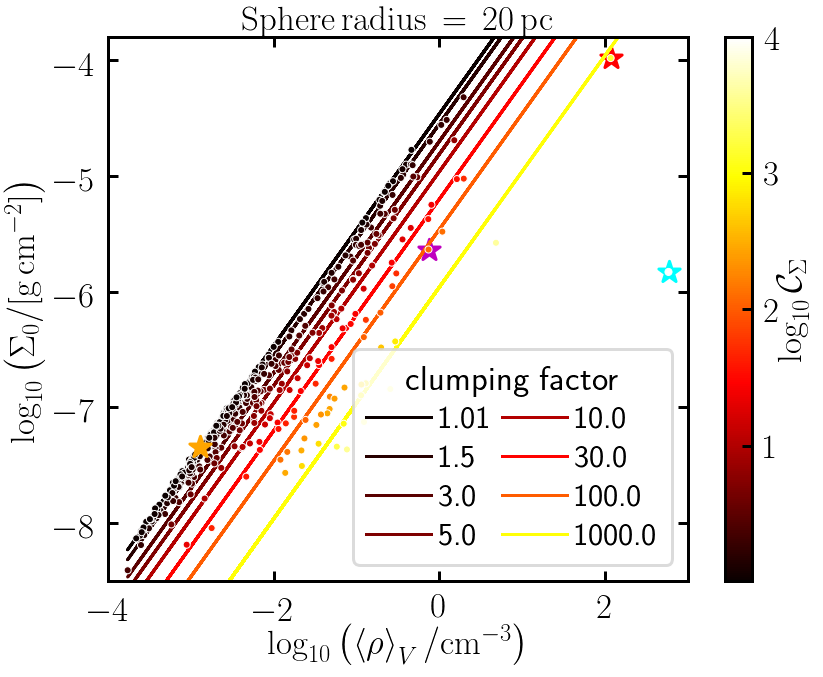

In [404]:
# column density vs. density
h = 1 #0
l = 2 #1

s = 2 #1
t = 2

k = 1

C = [1.01,1.5,3.,5.,10.,30.,100.,1000.,10000.]
logC = np.log10(C)
colors = plt.cm.hot(logC/logC[-1])#np.linspace(0,1,len(C)+3))

create_plot('./data/datav_500_nside4_1pc_R20_6000')
den, col_den, median_mp, avg_mp, centers = od_get_data('./data/datav_500_nside4_1pc_R20_6000')

for l in range(len(C)-1):
    plt.plot(np.log10(den/p_mass),np.log10((20*pc*den/3.)*C[l]**(-1/2.)), label=C[l], c=colors[l], zorder=-2)

    plt.legend(ncol=2,title="clumping factor",title_fontsize=35,fontsize=32.5, loc=4, columnspacing=0.25, handletextpad=0.25, labelspacing=0.25)

den, col_den, median_mp, avg_mp, centers = od_get_data('./data/datav_500_nside4_1pc_R20_6000')

plt.scatter(np.log10(den/p_mass)[hden][h],np.log10(median_mp/A_cm)[hden][h],marker='*',s=500,zorder=-10,c='r')

plt.scatter(np.log10(den/p_mass)[hden0][s],np.log10(median_mp/A_cm)[hden0][s],marker='*',s=500,zorder=-10,c='m')
plt.scatter(np.log10(den/p_mass)[lden0][t],np.log10(median_mp/A_cm)[lden0][t],marker='*',s=500,c='orange', zorder=11)

plt.scatter(np.log10(den/p_mass)[yellow],np.log10(median_mp/A_cm)[yellow],marker='*',s=500,zorder=-10,c='cyan')

plt.ylim(-8.5,-3.8)
plt.xlim(-4.,3.015)
plt.savefig("./plots/den_vs_col_den.pdf", bbox_inches='tight')

#### example column density distribution on the sphere

16.987206599744393


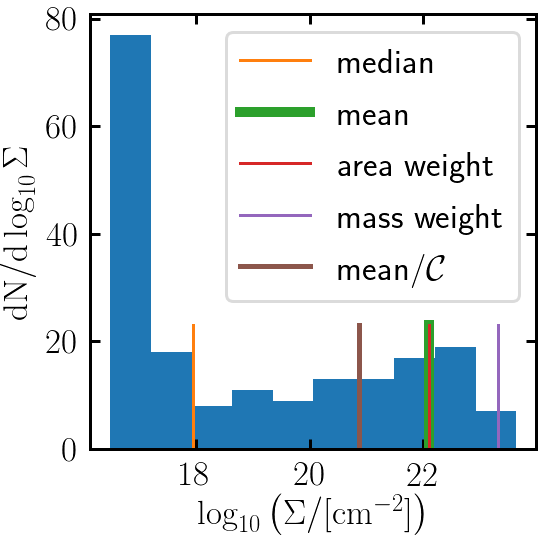

In [302]:
# cyan sphere
plt.figure(figsize=(8,8))
plt.hist(np.log10(col_den[yellow][0]*n_H/A_cm))

plt.plot([np.log10(np.median(col_den[yellow][0]*n_H/A_cm)),np.log10(np.median(col_den[yellow][0]*n_H/A_cm))],[0,23],label='median')
plt.plot([np.log10(np.mean(col_den[yellow][0]*n_H/A_cm)),np.log10(np.mean(col_den[yellow][0]*n_H/A_cm))],[0,23],lw=10,label='mean')

b = (col_den[yellow][0]*n_H/A_cm)
numer = np.sum(b*b)/(np.sum(b))
denom = np.sum(b)/(192)
av = numer/denom
plt.plot([np.log10(denom),np.log10(denom)],[0,23],label='area weight')
plt.plot([np.log10(numer),np.log10(numer)],[0,23],label='mass weight')

C = (numer/denom)
print(C)
plt.plot([np.log10(np.mean(col_den[yellow][0]*n_H/A_cm)/C),np.log10(np.mean(col_den[yellow][0]*n_H/A_cm)/C)],[0,23],lw=5,label=r'mean/$\mathcal{C}$')

plt.xlabel(r'$\log_{10}\left(\Sigma/[\rm{cm}^{-2}]\right)$')
plt.ylabel(r'$\rm{d}N/\rm{d}\log_{10}\Sigma$')
plt.legend(fontsize=35)
plt.savefig("./plots/col_den_hist_cyan.pdf", bbox_inches='tight')

1.0267819206333906


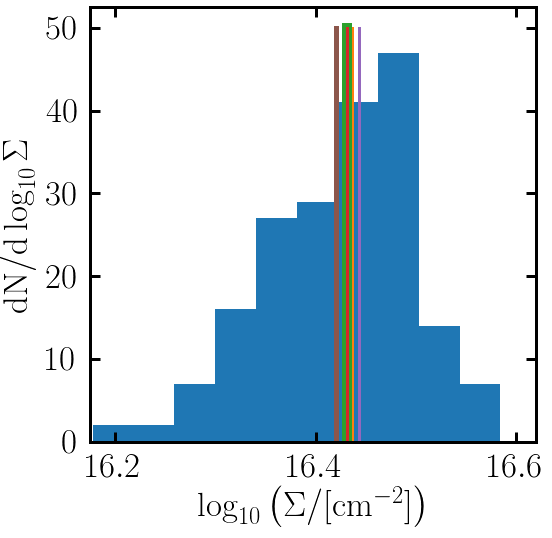

In [303]:
# orange sphere
plt.figure(figsize=(8,8))
plt.hist(np.log10(col_den[lden0][t]*n_H/A_cm))
plt.plot([np.log10(np.median(col_den[lden0][t]*n_H/A_cm)),np.log10(np.median(col_den[lden0][t]*n_H/A_cm))],[0,50],label='median')
plt.plot([np.log10(np.mean(col_den[lden0][t]*n_H/A_cm)),np.log10(np.mean(col_den[lden0][t]*n_H/A_cm))],[0,50],lw=10,label='mean')

b = col_den[lden0][t]*n_H/A_cm # [lden0][t]  *n_H
numer = np.sum(b*b*A_cm)/(np.sum(b*A_cm))
denom = np.sum(b*A_cm)/(192*A_cm)
#av = numer/denom
plt.plot([np.log10(denom),np.log10(denom)],[0,50],label='area weight')
plt.plot([np.log10(numer),np.log10(numer)],[0,50],label='mass weight')

C = (numer/denom)
print(C)
plt.plot([np.log10(np.mean(col_den[lden0][t]*n_H/A_cm)/C),np.log10(np.mean(col_den[lden0][t]*n_H/A_cm)/C)],[0,50],lw=5,label=r'mean/$\mathcal{C}$')

plt.xlabel(r'$\log_{10}\left(\Sigma/[\rm{cm}^{-2}]\right)$')
plt.ylabel(r'$\rm{d}N/\rm{d}\log_{10}\Sigma$')
#plt.legend(fontsize=25)
plt.xlim(16.175,16.62)
plt.savefig("./plots/col_den_hist_orange.pdf", bbox_inches='tight')

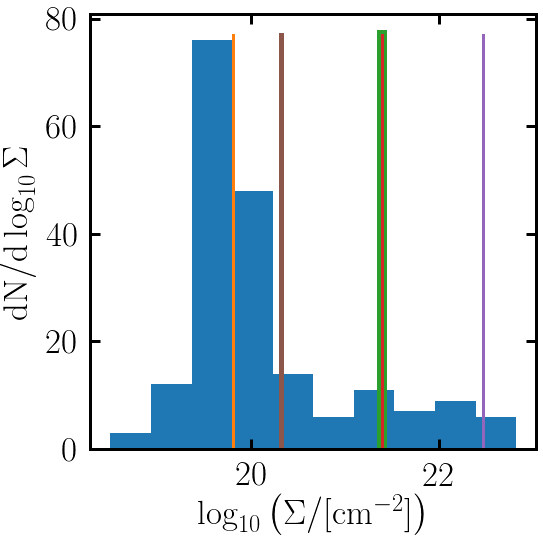

In [304]:
# red sphere
plt.figure(figsize=(8,8))
plt.hist(np.log10(col_den[hden][h]*n_H/A_cm))
plt.plot([np.log10(np.median(col_den[hden][h]*n_H/A_cm)),np.log10(np.median(col_den[hden][h]*n_H/A_cm))],[0,77],label='median')
plt.plot([np.log10(np.mean(col_den[hden][h]*n_H/A_cm)),np.log10(np.mean(col_den[hden][h]*n_H/A_cm))],[0,77],lw=10,label='mean')


b = col_den[hden][h]*n_H/A_cm # [lden0][t]  *n_H
numer = np.sum(b*b*A_cm)/(np.sum(b*A_cm))
denom = np.sum(b*A_cm)/(192*A_cm)

plt.plot([np.log10(denom),np.log10(denom)],[0,77],label='area weight')
plt.plot([np.log10(numer),np.log10(numer)],[0,77],label='mass weight')

C = (numer/denom)
plt.plot([np.log10(np.mean(col_den[hden][h]*n_H/A_cm)/C),np.log10(np.mean(col_den[hden][h]*n_H/A_cm)/C)],[0,77],lw=5,label=r'mean/$\mathcal{C}$')


plt.xlabel(r'$\log_{10}\left(\Sigma/[\rm{cm}^{-2}]\right)$')
plt.ylabel(r'$\rm{d}N/\rm{d}\log_{10}\Sigma$')
#plt.legend(fontsize=25, loc=1)
plt.savefig("./plots/col_den_hist_red.pdf", bbox_inches='tight')

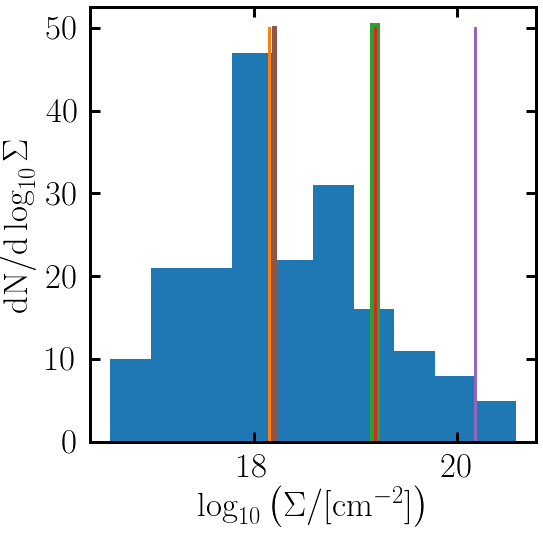

In [305]:
# purple sphere
plt.figure(figsize=(8,8))
plt.hist(np.log10(col_den[hden0][s]*n_H/A_cm))
plt.plot([np.log10(np.median(col_den[hden0][s]*n_H/A_cm)),np.log10(np.median(col_den[hden0][s]*n_H/A_cm))],[0,50],label='median')
plt.plot([np.log10(np.mean(col_den[hden0][s]*n_H/A_cm)),np.log10(np.mean(col_den[hden0][s]*n_H/A_cm))],[0,50],lw=10,label='mean')

b = col_den[hden0][s]*n_H/A_cm # [lden0][t]  *n_H
numer = np.sum(b*b*A_cm)/(np.sum(b*A_cm))
denom = np.sum(b*A_cm)/(192*A_cm)
av = numer/denom

plt.plot([np.log10(denom),np.log10(denom)],[0,50],label='area weight')
plt.plot([np.log10(numer),np.log10(numer)],[0,50],label='mass weight')

C = (numer/denom)
plt.plot([np.log10(np.mean(col_den[hden0][s]*n_H/A_cm)/C),np.log10(np.mean(col_den[hden0][s]*n_H/A_cm)/C)],[0,50],lw=5,label=r'mean/$\mathcal{C}$')

plt.xlabel(r'$\log_{10}\left(\Sigma/[\rm{cm}^{-2}]\right)$')
plt.ylabel(r'$\rm{d}N/\rm{d}\log_{10}\Sigma$')
#plt.legend(fontsize=25, loc=1)
plt.savefig("./plots/col_den_hist_purple.pdf", bbox_inches='tight')

### Figure 5: comparing data to model predictions

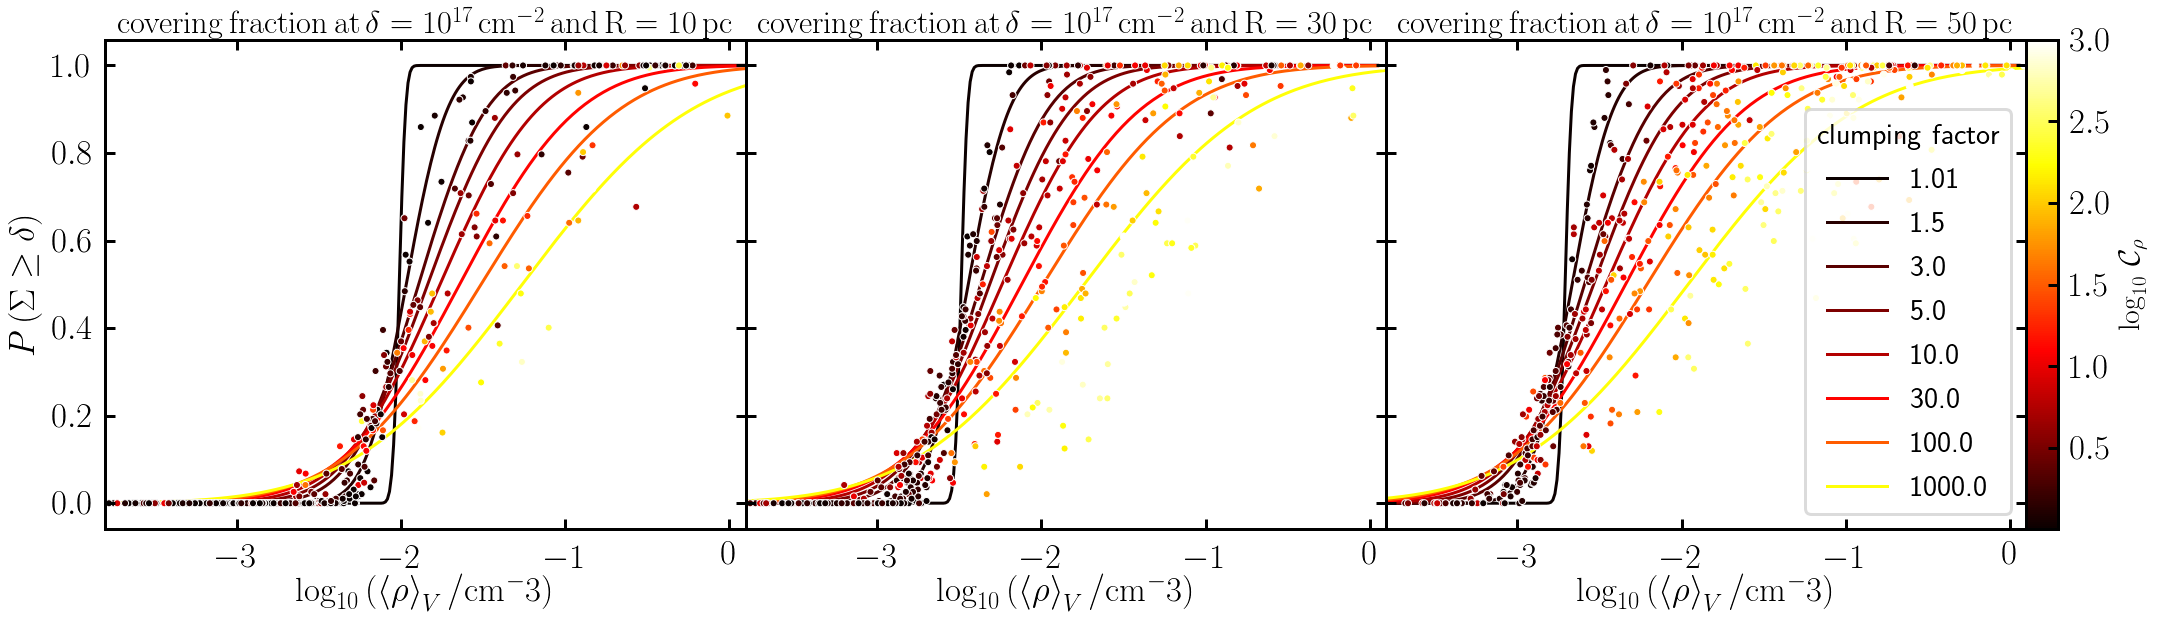

In [336]:
# old version of Fig. 5:

plt.figure(figsize=(35,9))
gs = gridspec.GridSpec(1, 4, width_ratios=[1,1,1,0.05], height_ratios=[1])
gs.update(hspace=0.0, wspace=0.0)

cax = plt.subplot(gs[-1])
ax = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

th = 10**17

C = [1.01,1.5,3.,5.,10.,30.,100.,1000.,10000.]
logC = np.log10(C)
colors = plt.cm.hot(logC/logC[-1])#np.linspace(0,1,len(C)+3))
dens = np.linspace(-4,1,400)

for i in range(len(C)-1):
    ax.plot(dens,volume_errf(10**dens,10,C[i],th),color=colors[i], label=C[i], zorder=-10)#, ls='dashed')
    ax1.plot(dens,volume_errf(10**dens,30,C[i],th),color=colors[i], label=C[i], zorder=-10)#, ls='dashed')
    ax2.plot(dens,volume_errf(10**dens,50,C[i],th),color=colors[i], label=C[i], zorder=-10)#, ls='dashed')

for name,axis,rad in zip(['./data/data_cellprop_500_nside4_1pc_R10_6000','./data/data_cellprop_500_nside4_1pc_R30_6000',
                          './data/data_cellprop_500_nside4_1pc_R50_6000'],[ax,ax1,ax2],[10,30,50]):
    
    with open(name, "rb") as all_data:
        data = pickle.load(all_data)
    
    #data = od_get_data(name)
    vel_disp = data["vel_disp"]
    cell_masses = data["cell_masses"]
    cell_volumes  = data["cell_volumes"]
    den = data["density"] / p_mass

    col_den = data["column_density"]
    median_mp = data["median"] 
    avg_mp = data["average"]
    centers = data["centers"]
    
    pc = 3.085e18

    nside = 4 #int(nums[1])
    A = 4 * np.pi * (rad*pc)**2

    #area of a pixel in cm^2
    A_cm = A/hp.nside2npix(nside)
    n_H = 6.026e+23 #number of hydrogen atoms in one gram of gas

    #clumping factor computation
    cf0 = []
    cf1 = []
    density = []
    covering = []
    d = cell_masses/cell_volumes
    v = cell_volumes

    density.extend(den)

    for i in range(500):
        mean = np.mean(d[i])
        median = np.median(d[i])
        tmp = np.mean(cell_masses[i])
        cf0.append(tmp/np.median(cell_masses[i]))

    clump = np.asarray(cf0) 
    log_clump = np.log10(np.exp(2*np.log(clump))) # factor 2 comes in because we use mean and median to calculate 
                                    #the clumping factor. See explanantion to Eq. 10 in Buck et al. 2021b

    #particles per cm^2 
    b = col_den/(A_cm*p_mass)
    cov = []
    for i in range(len(col_den)):
        cov.append(len(np.where(b[i] > th)[0])/(len(b[0])))
    
    covering.extend(cov)
    
    cc = axis.scatter(np.log10(density), covering, c=log_clump, edgecolor='w',lw=1,
                s=50,cmap='hot',vmin=np.log10(1.01), vmax=3)

    axis.set_xlim(-3.8,0.1)
    axis.set_xlabel(r"$\log_{10}\left(\left<\rho\right>_V/\rm{cm}{^-3}\right)$",labelpad=10)
    axis.set_title(r"$\rm{covering\, fraction\, at\, \delta=10^{17}\,\rm{cm}^{-2}\, and\, R=%s\,\rm{pc}}$"%rad, fontsize=32.5)


ax2.legend(title="clumping factor",title_fontsize=30,fontsize=30,loc=4)
ax.set_ylabel(r"$P\left(\Sigma\geq\delta\right)$",labelpad=10)
ax1.set_yticklabels([])
ax2.set_yticklabels([])
cb = plt.colorbar(cc, cax=cax)
cb.set_label(label=r"$\log_{10}\,\mathcal{C}_\rho$", size=30, labelpad=10)

plt.savefig("./plots/theory_vs_data.pdf", bbox_inches='tight')

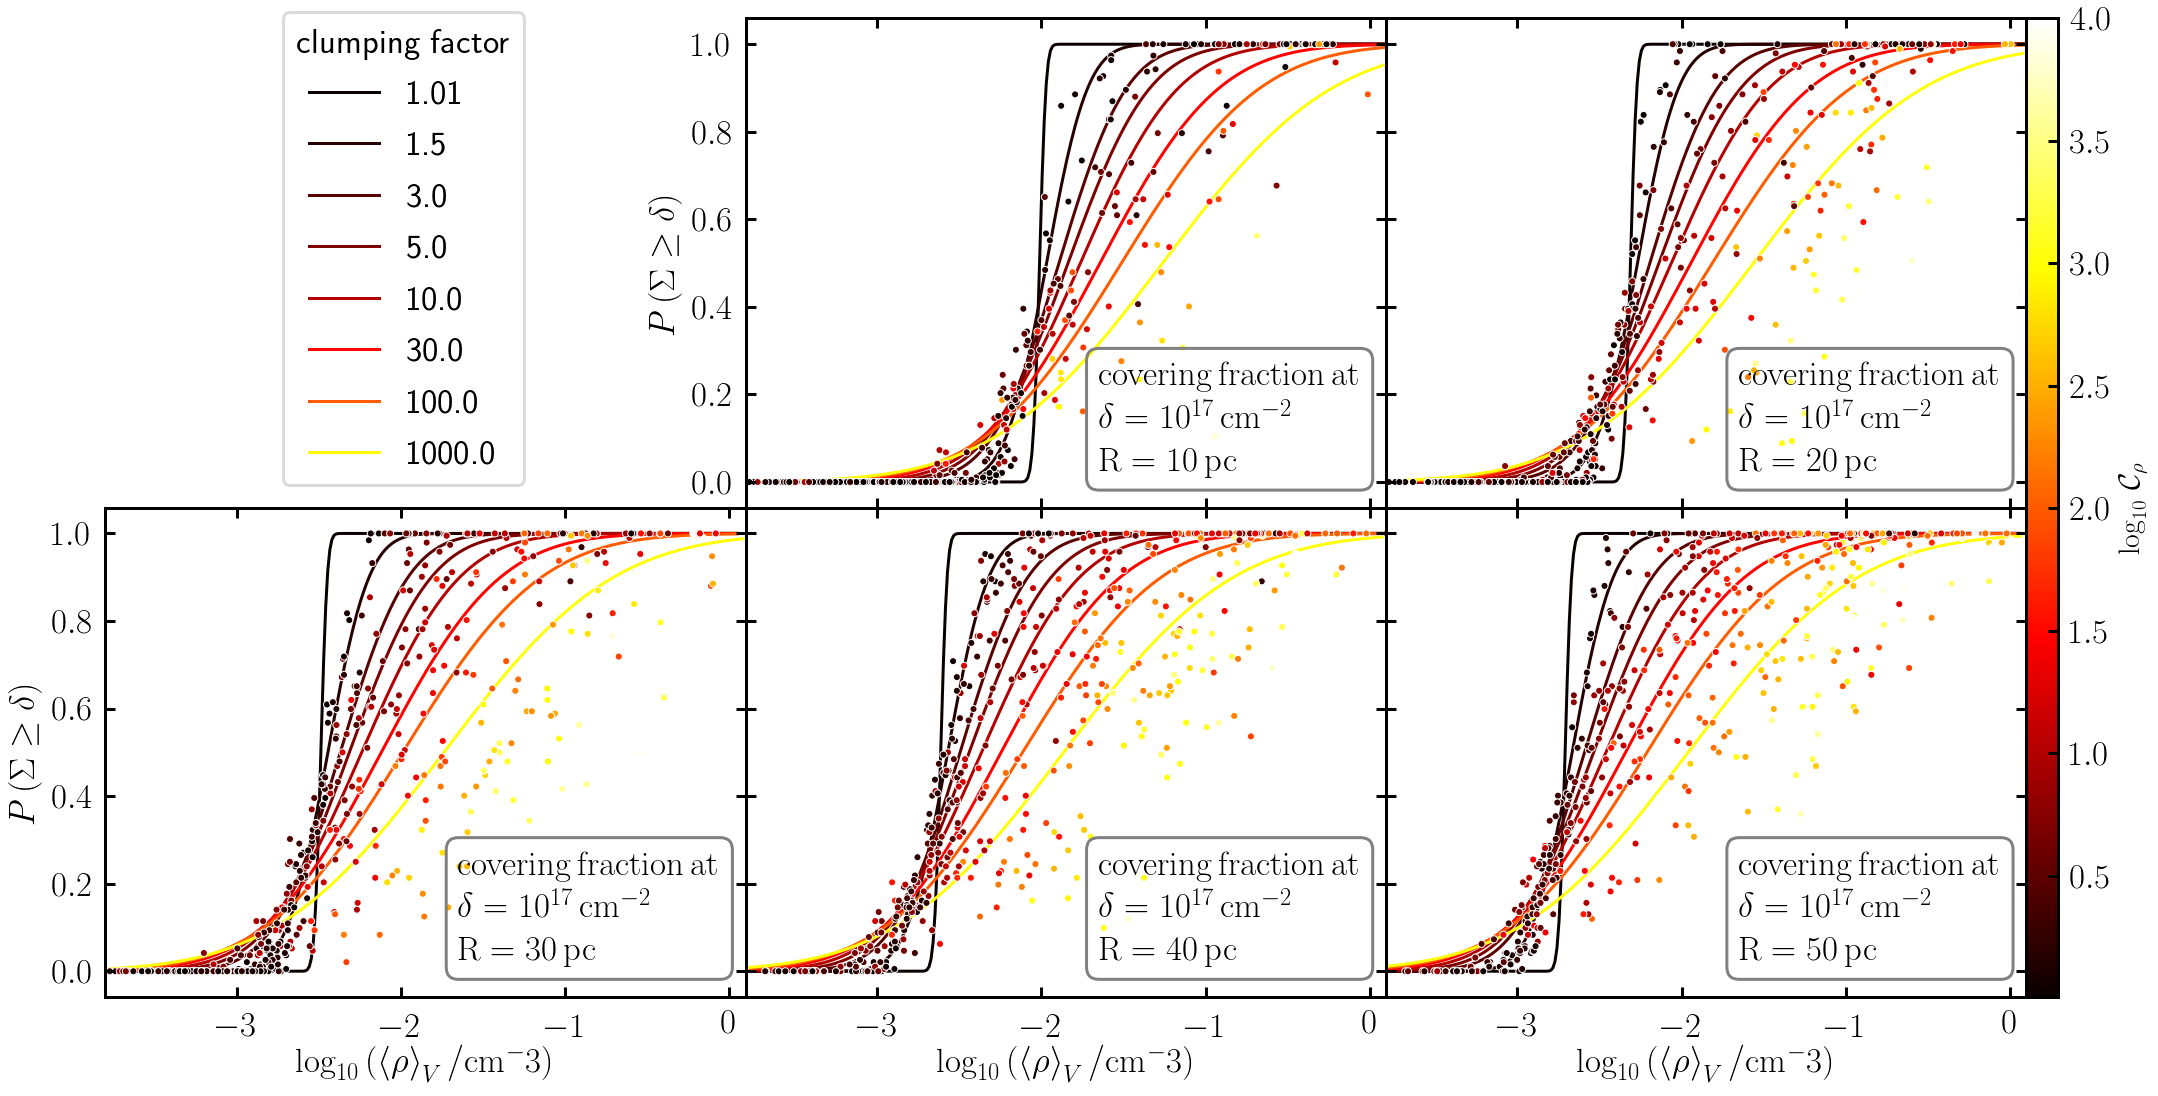

In [405]:
# Fig. 5:

plt.figure(figsize=(35,18))
gs = gridspec.GridSpec(2, 4, width_ratios=[1,1,1,0.05], height_ratios=[1,1])
gs.update(hspace=0.0, wspace=0.0)

cax = plt.subplot(gs[:,-1])
ax = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[4])
ax4 = plt.subplot(gs[5])
ax5 = plt.subplot(gs[6])


th = 10**17

C = [1.01,1.5,3.,5.,10.,30.,100.,1000.,10000.]
logC = np.log10(C)
colors = plt.cm.hot(logC/logC[-1])#np.linspace(0,1,len(C)+3))
dens = np.linspace(-4,1,400)

for i in range(len(C)-1):
    ax1.plot(dens,volume_errf(10**dens,10,C[i],th),color=colors[i], label=C[i], zorder=-10)#, ls='dashed')
    ax2.plot(dens,volume_errf(10**dens,20,C[i],th),color=colors[i], label=C[i], zorder=-10)#, ls='dashed')
    ax3.plot(dens,volume_errf(10**dens,30,C[i],th),color=colors[i], label=C[i], zorder=-10)#, ls='dashed')
    ax4.plot(dens,volume_errf(10**dens,40,C[i],th),color=colors[i], label=C[i], zorder=-10)#, ls='dashed')
    ax5.plot(dens,volume_errf(10**dens,50,C[i],th),color=colors[i], label=C[i], zorder=-10)#, ls='dashed')

for name,axis,rad in zip(['./data/data_cellprop_500_nside4_1pc_R10_6000','./data/data_cellprop_500_nside4_1pc_R20_6000','./data/data_cellprop_500_nside4_1pc_R30_6000',
                          './data/data_cellprop_500_nside4_1pc_R40_6000','./data/data_cellprop_500_nside4_1pc_R50_6000'],[ax1,ax2,ax3,ax4,ax5],[10,20,30,40,50]):
    
    with open(name, "rb") as all_data:
        data = pickle.load(all_data)
    
    #data = od_get_data(name)
    vel_disp = data["vel_disp"]
    cell_masses = data["cell_masses"]
    cell_volumes  = data["cell_volumes"]
    den = data["density"] / p_mass

    col_den = data["column_density"]
    median_mp = data["median"] 
    avg_mp = data["average"]
    centers = data["centers"]
    
    pc = 3.085e18

    nside = 4 #int(nums[1])
    A = 4 * np.pi * (rad*pc)**2

    #area of a pixel in cm^2
    A_cm = A/hp.nside2npix(nside)
    n_H = 6.026e+23 #number of hydrogen atoms in one gram of gas

    #clumping factor computation
    cf0 = []
    cf1 = []
    density = []
    covering = []
    d = cell_masses/cell_volumes
    v = cell_volumes

    density.extend(den)

    for i in range(500):
        mean = np.mean(d[i])
        median = np.median(d[i])
        tmp = np.mean(cell_masses[i])
        cf0.append(tmp/np.median(cell_masses[i]))

    clump = np.asarray(cf0) 
    log_clump = np.log10(np.exp(2*np.log(clump))) # factor 2 comes in because we use mean and median to calculate 
                                    #the clumping factor. See explanantion to Eq. 10 in Buck et al. 2021b

    #particles per cm^2 
    b = col_den/(A_cm*p_mass)
    cov = []
    for i in range(len(col_den)):
        cov.append(len(np.where(b[i] > th)[0])/(len(b[0])))
    
    covering.extend(cov)
    
    cc = axis.scatter(np.log10(density), covering, c=log_clump, edgecolor='w',lw=1,
                s=50,cmap='hot',vmin=np.log10(1.01), vmax=4)

    axis.set_xlim(-3.8,0.1)
    if rad > 20:
        axis.set_xlabel(r"$\log_{10}\left(\left<\rho\right>_V/\rm{cm}{^-3}\right)$",labelpad=12)
    #axis.set_title(r"$\rm{covering\, fraction\, at\, \delta=10^{17}\,\rm{cm}^{-2}\, and\, R=%s\,\rm{pc}}$"%rad, fontsize=32.5)
    axis.text(-1.65,0.025,r"$\rm{covering\, fraction\, at}$" +"\n"+ r"$\rm{\delta=10^{17}\,\rm{cm}^{-2}}$" +"\n" + r"$\rm{R=%s\,\rm{pc}}$"%rad,fontsize=35,linespacing=1.5, bbox=dict(facecolor='none', edgecolor='gray', boxstyle='round, pad=.35'))
    #axis.text(-3.75,0.8,r"$\rm{\delta=10^{17}\,\rm{cm}^{-2} R=%s\,\rm{pc}}$"%rad,fontsize=35)

ax1.legend(title="clumping factor",title_fontsize=35,fontsize=35,loc=2, bbox_to_anchor=(-.75, 1.05))
ax.set_ylabel(r"$P\left(\Sigma\geq\delta\right)$",labelpad=10)
ax3.set_ylabel(r"$P\left(\Sigma\geq\delta\right)$",labelpad=10)
ax1.set_ylabel(r"$P\left(\Sigma\geq\delta\right)$",labelpad=10)
ax2.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax.set_axis_off()

cb = plt.colorbar(cc, cax=cax)
cb.set_label(label=r"$\log_{10}\,\mathcal{C}_\rho$", size=30, labelpad=10)

plt.savefig("./plots/theory_vs_data2.pdf", bbox_inches='tight')

## Application

###  Sampling clumping factors following the SILCC ISM distribution shown in Fig. 4

In [324]:
def get_parameter(density, radius):
    """
    This function returns the parameters for the gas clumping factors of the ISM 
    following the distribution derived from the SILCC simulations. 
    See Buck et al. 2021b, Figure 4 for more details.
    
    Input:
        density: Array of floats for ISM density on the spatial scale of radius 
                this assumes density is in units of particles per ccm and in log scale.
                
        radius: Array of floats containing the radius in pc of a spherical region over which 
                the density is measured.
    Returns:
        median and symmetrized scatterand standard deviation plus upper and lower quantile for the appropriate bin.
    """
    
    # clumping factor distribution parameters 
    dens_bins = [-3,-2,-1,0]
    r_bins = [10,20,30,40]
    
    # below values after the # are from a previous run with a different set of sphere centers  
    median_10 = [0.01823196, 0.04950165, 0.40800158, 0.23728883, 0.64220272] #[0.02794052, 0.04913394, 0.32441904, 0.24145827, 0.53303078]
    median_20 = [0.06306228, 0.11658668, 0.707515,   0.58052395, 1.21767977] #[0.07019885, 0.1362897,  0.56743725, 0.64022226, 1.43361638]
    median_30 = [0.11939972, 0.20888787, 0.85472721, 0.942905,   1.51777963] #[0.1213161,  0.24368286, 0.88562082, 0.90078494, 1.52757502]
    median_40 = [0.17016826, 0.50496672, 1.06984222, 1.34067668, 1.90155842] #[0.18315818, 0.5272019,  1.10784969, 1.12004373, 1.97793554]
    median_50 = [0.17595855, 0.60812958, 1.26232982, 1.47502842, 2.71062544] #[0.21085227, 0.70072905, 1.22446449, 1.46463611, 2.4378303 ]

    Hquant_10 = [0.0361681,  0.09038894, 0.59262425, 0.48274847, 0.66651319] #[0.04044243, 0.09926778, 0.59797796, 0.39866323, 0.60150491]
    Hquant_20 = [0.09906523, 0.24253862, 0.9813001,  1.0400057,  1.52851613] #[0.10444634, 0.27379429, 0.83930511, 1.04099459, 1.52386082]
    Hquant_30 = [0.21208288, 0.53716421, 1.04453789, 1.35361906, 1.64081173] #[0.16085639, 0.44164287, 1.0823171,  1.27506086, 2.51002071]
    Hquant_40 = [0.23164379, 0.90465103, 1.36449426, 1.5546307,  2.14764485] #[0.25446791, 0.89330849, 1.32116409, 1.46943128, 2.44072535]
    Hquant_50 = [0.22020638, 0.93049567, 1.61833564, 1.74061565, 3.12480777] #[0.32355365, 1.08286413, 1.57732272, 1.78032719, 2.69268363]

    Lquant_10 = [0.00943279, 0.03068964, 0.24959986, 0.15808746, 0.63001399] #[0.01485397, 0.0237583,  0.18621637, 0.17295991, 0.45024002]
    Lquant_20 = [0.03936704, 0.07692006, 0.47716257, 0.39683873, 1.06833693] #[0.04289128, 0.09128546, 0.47701008, 0.45693048, 1.17021003]
    Lquant_30 = [0.088102,   0.13780616, 0.7525913,  0.65126785, 1.36917891] #[0.09263849, 0.14218906, 0.77400885, 0.50675566, 1.48853796]
    Lquant_40 = [0.12205925, 0.27623866, 0.93284064, 0.84931631, 1.71505479] #[0.1431963,  0.29747549, 0.95558619, 0.82678924, 1.76947263]
    Lquant_50 = [0.16793465, 0.32123832, 1.04359751, 1.25722623, 2.62515156] #[0.15339995, 0.41579495, 1.05109814, 1.28462236, 2.21043329]
    
    # symmetric scatter defined via the std of the data seems to over estimate the scatter.
    # let's symmetrize the quantiles and use this as scatter for a gaussian curve... 
    std_10 = [0.04353856, 0.22243294, 0.33285231, 0.48291184, 0.15057272] #[0.17742603, 0.32948374, 0.37054875, 0.32734455, 0.20356212]
    std_20 = [0.15941194, 0.36498988, 0.56312068, 0.49827186, 0.42939486] #[0.18328545, 0.37937774, 0.50643965, 0.58048595, 0.54214008]
    std_30 = [0.23994565, 0.5430825,  0.58520962, 0.6103143,  0.39913176] #[0.21087869, 0.53316427, 0.51893808, 0.65891835, 0.75870527]
    std_40 = [0.23331981, 0.58807461, 0.58426011, 0.64672174, 0.48207867] #[0.27228757, 0.61057632, 0.52689293, 0.73675552, 0.59135776]
    std_50 = [0.24480969, 0.66198969, 0.7114604,  0.83451308, 0.57012594] #[0.26385584, 0.62778011, 0.67156235, 0.81329501, 0.56698674]

    # symmetrize the quantiles to calculate new symmetric scatter.
    sym_quant_10 = [(h-l)/2. for h,l in zip(Hquant_10,Lquant_10)]
    sym_quant_20 = [(h-l)/2. for h,l in zip(Hquant_20,Lquant_20)]
    sym_quant_30 = [(h-l)/2. for h,l in zip(Hquant_30,Lquant_30)]
    sym_quant_40 = [(h-l)/2. for h,l in zip(Hquant_40,Lquant_40)]
    sym_quant_50 = [(h-l)/2. for h,l in zip(Hquant_50,Lquant_50)]
    
    # for ease of later use, let's combine them into a single 2d array
    medians = [median_10,median_20,median_30,median_40,median_50]
    Hquants = [Hquant_10,Hquant_20,Hquant_30,Hquant_40,Hquant_50]
    Lquants = [Lquant_10,Lquant_20,Lquant_30,Lquant_40,Lquant_50]
    Squants = [sym_quant_10,sym_quant_20,sym_quant_30,sym_quant_40,sym_quant_50]
    std = [std_10,std_20,std_30,std_40,std_50]
    
    d = np.searchsorted(dens_bins, density, side='left')
    r = np.searchsorted(r_bins, radius, side='left')
    
    med = [medians[r][d] for d,r in zip(d,r)]
    Sq = [Squants[r][d] for d,r in zip(d,r)]
    Hq = [Hquants[r][d] for d,r in zip(d,r)]
    Lq = [Lquants[r][d] for d,r in zip(d,r)]
    st = [std[r][d] for d,r in zip(d,r)]
    
    return med, Sq, st, Hq, Lq

In [325]:
def sample_clumping_factor(density, radius, scatter_type='sym', sample_size=1000):
    """
    This function samples gas clumping factors of the ISM following the distribution derived 
    from the SILCC simulations. See Buck et al. 2021b, Figure 4 for more details.
    
    Input:
        density: Array of floats for ISM density on the spatial scale of radius 
                this assumes density is in units of particles per ccm and in log scale.
                
        radius: Array of floats containing the radius in pc of a spherical region over which 
                the density is measured.
        
        scatter_type: string specifying which kind of scatter to use. 'sym' selects symmetrized scatter 
                        based on quantiles, 'std' uses plain standard deviation
                
        sample_size: for each density radius pair, how many samples should be drawn.
    Reurns:
        logarithm base 10 of the clumping factor. Array of floats with shape (len(density),sample_size)
    """
    
    dsize = len(density)
    rsize = len(radius)
    #check if density and radius array have same length
    assert(dsize == rsize)
    
    # get clumping factor distribution parameter 
    m, s, std, _, _ = get_parameter(density, radius)
    
    # sample clumping factor following normal distribution
    if scatter_type == 'sym':
        sample = [np.random.normal(mu, sigma, sample_size) for mu,sigma in zip(m,s)]
    if scatter_type == 'std':
        sample = [np.random.normal(mu, sigma, sample_size) for mu,sigma in zip(m,std)]
        
    return sample

In [328]:
# err function equation 27 in Buck et al. 2021b
def covering_fraction(density, radius, c, delta):
    """
    This function returns the covering fraction as a function of log density/ccm for a given
    spatial scale of radius r in pc, correpsonding clumping factor c and threshold column density delta
    in log surface density. See Buck et al. 2021b, equation 26. 
    
    Input:
        density: float for ISM density on the spatial scale of radius 
                this assumes density is in units of particles per ccm. 
        
        radius: float containing the radius in pc of a spherical region over which 
                the density is measured.
        
        c: floats containing the clumping factor.
        
        delta: threshold column density in particle/cm^2
    """
    rho_hat = 3 * delta / ( radius * pc * density)
    mu_hat = - np.log( c ) / 4.
    sigma_hat = np.sqrt( 0.5 * np.log(c) )

    z = ( np.log(rho_hat) - mu_hat ) / ( np.sqrt(2) * sigma_hat )
    return 0.5 * ( 1 - special.erf(z) )

/Users/buck/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


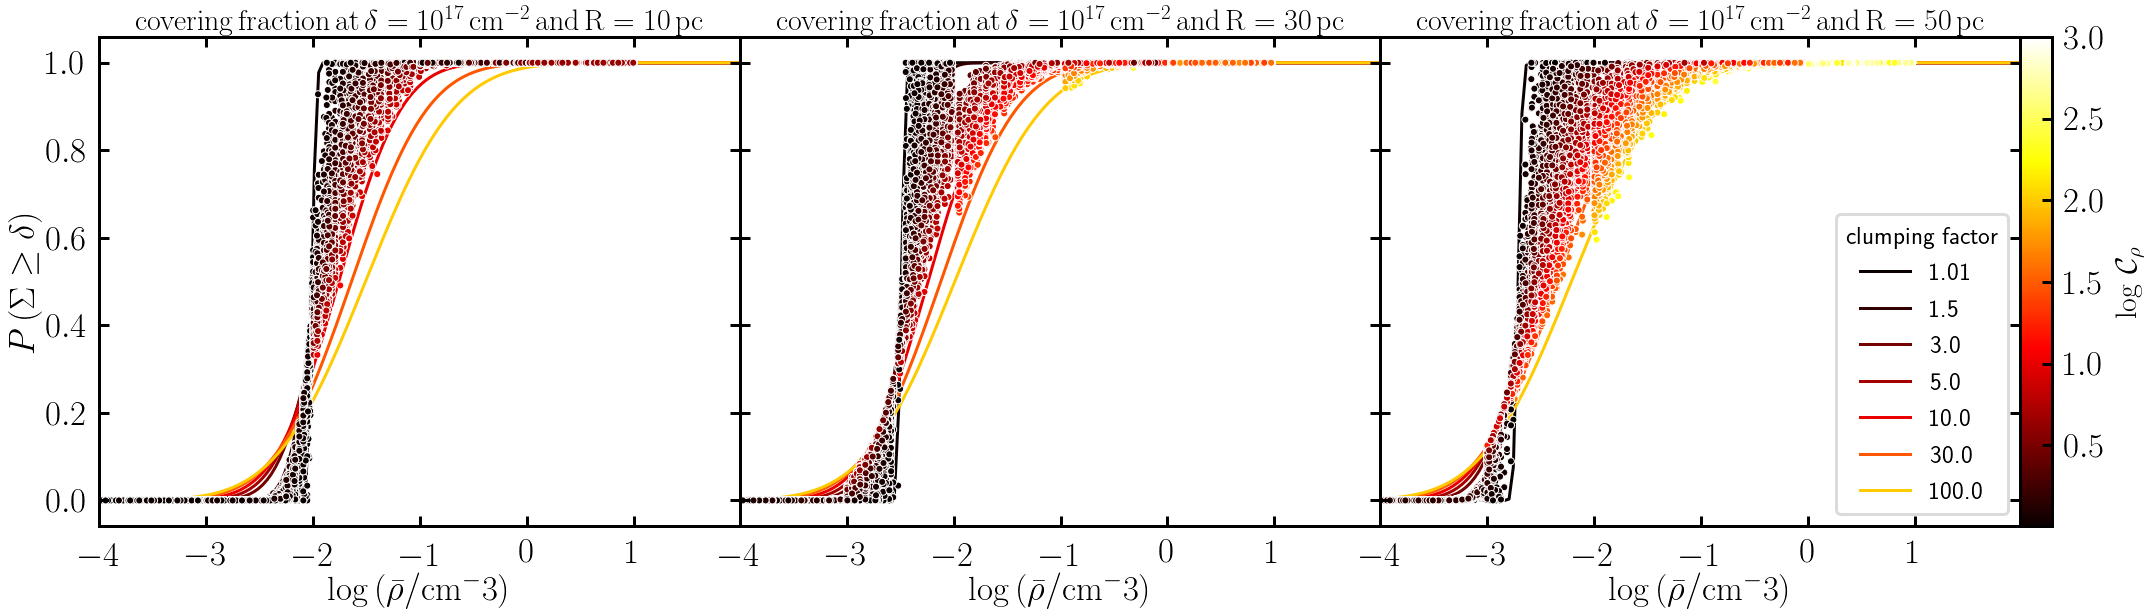

In [406]:
# Compare random sampling to theory -- here with symmetrized scatter from averaging quantiles

plt.figure(figsize=(35,9))
gs = gridspec.GridSpec(1, 4, width_ratios=[1,1,1,0.05], height_ratios=[1])
gs.update(hspace=0.0, wspace=0.0)

cax = plt.subplot(gs[-1])
ax = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

th = 10**17

C = [1.01,1.5,3.,5.,10.,30.,100.,1000.]
logC = np.log10(C)
colors = plt.cm.hot(logC/logC[-1])#np.linspace(0,1,len(C)+3))
dens = np.linspace(-4,4,200)

for i in range(len(C)-1):
    ax.plot(dens,covering_fraction(10**dens,10,C[i],th),color=colors[i], label=C[i], zorder=-10) 
    ax1.plot(dens,covering_fraction(10**dens,30,C[i],th),color=colors[i], label=C[i], zorder=-10) 
    ax2.plot(dens,covering_fraction(10**dens,50,C[i],th),color=colors[i], label=C[i], zorder=-10)

    
den_bin = [-3.5,-2.5,-1.5,-0.5,0.5]
sample = 100
rad = [10,30,50]

# for each bin in density sample a hundred random numbers
# we use a fixed radius of 20 pc 
for r, axis in zip(rad,[ax,ax1,ax2]):
    for d in den_bin:
        density = np.random.uniform(d-0.5,d+0.5,sample)
        radius = np.asarray([r]*sample)
    
        # let's sample some clumping factors for the density, radius pairs
        clump = sample_clumping_factor(np.asarray(density),radius, sample_size=sample)
        for c in clump:
            covering = covering_fraction(10**density,radius,10**c,th)
            cc = axis.scatter(density, covering, c=c, edgecolor='w',lw=1,
                s=50,cmap='hot',vmin=np.log10(1.01), vmax=3)#, zorder=-20)

    axis.set_xlim(-4,1.99)
    axis.set_xlabel(r"$\log\left(\bar\rho/\rm{cm}{^-3}\right)$")
    axis.set_title(r"$\rm{covering\, fraction\, at\, \delta=10^{17}\,\rm{cm}^{-2}\, and\, R=%s\,\rm{pc}}$"%r, fontsize=30)


ax2.legend(title="clumping factor",title_fontsize=25,fontsize=25,loc=4)
ax.set_ylabel(r"$ P\left(\Sigma\geq\delta\right)$")#\,
ax1.set_yticklabels([])
ax2.set_yticklabels([])
cb = plt.colorbar(cc, cax=cax)
cb.set_label(label=r"$\log\,\mathcal{C}_\rho$", size=30, labelpad=10)

#plt.savefig("theory_vs_data.pdf", bbox_inches='tight')

/Users/buck/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


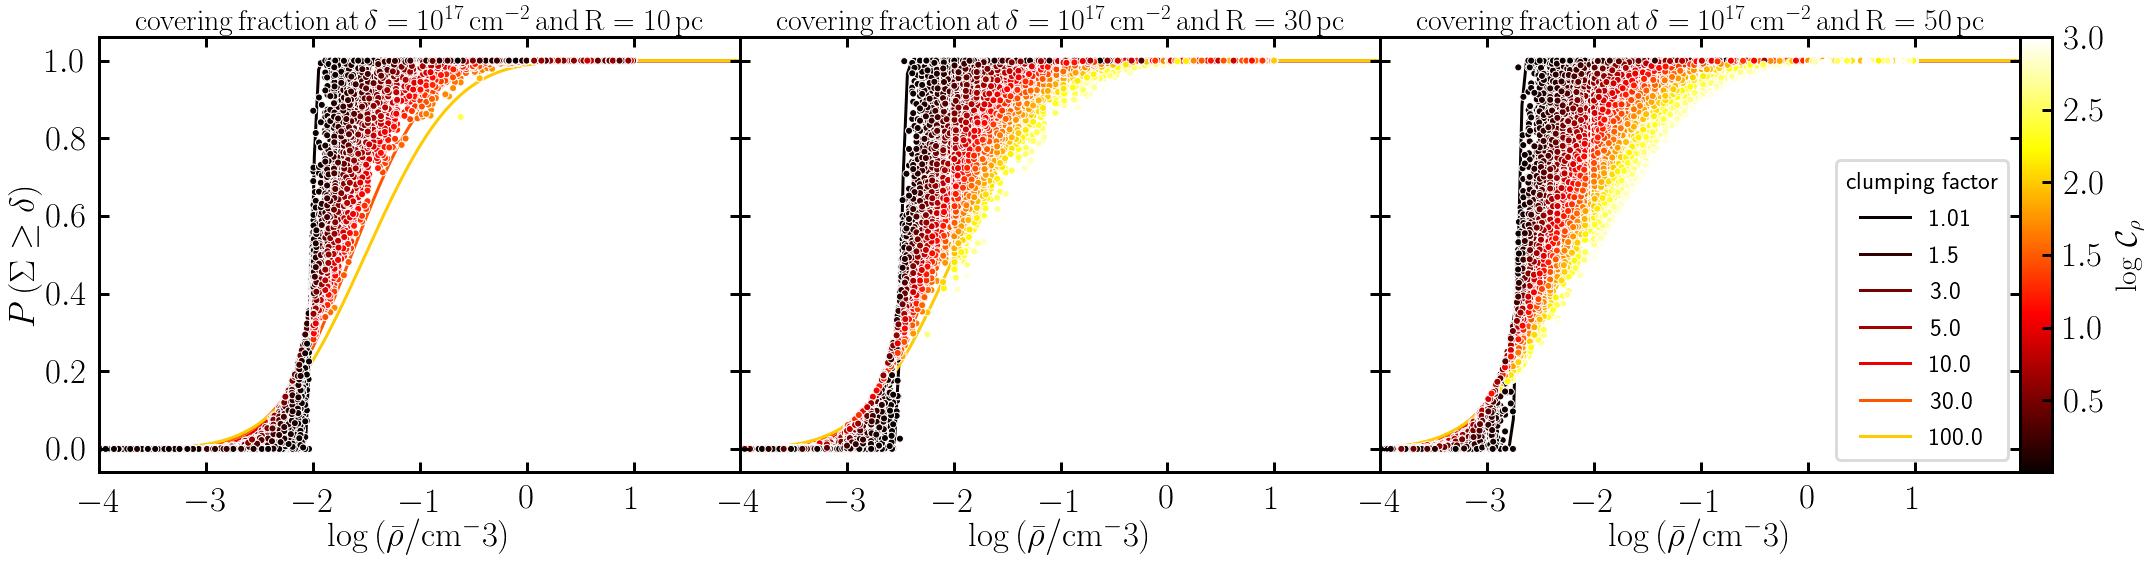

In [407]:
# Compare random sampling to theory -- here with plain standard deviation 

plt.figure(figsize=(35,8))
gs = gridspec.GridSpec(1, 4, width_ratios=[1,1,1,0.05], height_ratios=[1])
gs.update(hspace=0.0, wspace=0.0)

cax = plt.subplot(gs[-1])
ax = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

th = 10**17

C = [1.01,1.5,3.,5.,10.,30.,100.,1000.]
logC = np.log10(C)
colors = plt.cm.hot(logC/logC[-1])#np.linspace(0,1,len(C)+3))
dens = np.linspace(-4,4,200)

for i in range(len(C)-1):
    ax.plot(dens,covering_fraction(10**dens,10,C[i],th),color=colors[i], label=C[i], zorder=-10) 
    ax1.plot(dens,covering_fraction(10**dens,30,C[i],th),color=colors[i], label=C[i], zorder=-10) 
    ax2.plot(dens,covering_fraction(10**dens,50,C[i],th),color=colors[i], label=C[i], zorder=-10)

    
den_bin = [-3.5,-2.5,-1.5,-0.5,0.5]
sample = 100
rad = [10,30,50]

# for each bin in density sample a hundred random numbers
# we use a fixed radius of 20 pc 
for r, axis in zip(rad,[ax,ax1,ax2]):
    for d in den_bin:
        density = np.random.uniform(d-0.5,d+0.5,sample)
        radius = np.asarray([r]*sample)
    
        # let's sample some clumping factors for the density, radius pairs
        clump = sample_clumping_factor(np.asarray(density),radius, scatter_type='std', sample_size=sample)
        for c in clump:
            covering = covering_fraction(10**density,radius,10**c,th)
            cc = axis.scatter(density, covering, c=c, edgecolor='w',lw=1,
                s=50,cmap='hot',vmin=np.log10(1.01), vmax=3)#, zorder=-20)

    axis.set_xlim(-4,1.99)
    axis.set_xlabel(r"$\log\left(\bar\rho/\rm{cm}{^-3}\right)$")
    axis.set_title(r"$\rm{covering\, fraction\, at\, \delta=10^{17}\,\rm{cm}^{-2}\, and\, R=%s\,\rm{pc}}$"%r, fontsize=30)


ax2.legend(title="clumping factor",title_fontsize=25,fontsize=25,loc=4)
ax.set_ylabel(r"$ P\left(\Sigma\geq\delta\right)$")#\,
ax1.set_yticklabels([])
ax2.set_yticklabels([])
cb = plt.colorbar(cc, cax=cax)
cb.set_label(label=r"$\log\,\mathcal{C}_\rho$", size=30, labelpad=10)

#plt.savefig("theory_vs_data.pdf", bbox_inches='tight')